In [1]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Diffusion Autoencoder Tutorial with Image Manipulation

This tutorial illustrates how to use MONAI Generative Models for training a 2D Diffusion Autoencoder model [1].

In summary, the tutorial will cover the following:
1. Loading and preprocessing a dataset (we extract the brain MRI dataset 2D slices from 3D volumes from the BraTS dataset);
2. Training a 2D diffusion model and semantic encoder with a ResNet18 backbone;
3. Evaluate the learned latent space by applying a Logistic Regression classifier and manipulating images with using the direction learned by the classifier.


During inference, the model encodes the image to latent space which is used as conditioning for the diffusion unet diffusion model. [1] trains a latent diffusion model for being able to generate unconditional images, which we do not do in this tutorial. Here, we are interested in checking wether the latent space contains classification information or not and if can be used to manipulate the images.

[1] Preechakul et al. [Diffusion Autoencoders: Toward a Meaningful and Decodable Representation](https://arxiv.org/abs/2111.15640). CVPR 2022

![image.png](https://diff-ae.github.io/images/diffae_overview.jpg)

## Setup imports

In [2]:
import os
import tempfile
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import sys
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import set_determinism
from sklearn.linear_model import LogisticRegression

from generative.inferers import DiffusionInferer
from generative.networks.nets.diffusion_model_unet import DiffusionModelUNet
from generative.networks.schedulers.ddim import DDIMScheduler

torch.multiprocessing.set_sharing_strategy("file_system")

print_config()

/remote/rds/users/s2086085/miniconda3/envs/pytorch_monai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 1.13.0+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /remote/rds/users/s2086085/miniconda3/envs/pytorch_monai/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 5.0.1
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.12.0
gdown version: 4.6.4
TorchVision version: 0.14.0+cu117
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.3
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

## Set deterministic training for reproducibility

In [4]:
set_determinism(42)

# Dataset preparation

## Setup BRATS Dataset  - Transforms for extracting 2D slices from 3D volumes

We now download the BraTS dataset and extract the 2D slices from the 3D volumes. The `slice_label` is used to indicate whether the slice contains an anomaly or not.

Here we use transforms to augment the training dataset, as usual:

1. `LoadImaged` loads the brain images from files.
2. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
3.  The first `Lambdad` transform chooses the first channel of the image, which is the Flair image.
4. `Spacingd` resamples the image to the specified voxel spacing, we use 3,3,2 mm.
5. `ScaleIntensityRangePercentilesd` Apply range scaling to a numpy array based on the intensity distribution of the input. Transform is very common with MRI images.
6. `RandSpatialCropd` randomly crop out a 2D patch from the 3D image.
6. The last `Lambdad` transform obtains `slice_label` by summing up the label to have a single scalar value (healthy `=1` or not `=2` ).

In [ ]:
channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.EnsureChannelFirstd(keys=["image", "label"]),
        transforms.Lambdad(keys=["image"], func=lambda x: x[channel, None, :, :, :]),
        transforms.EnsureTyped(keys=["image", "label"]),
        transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
        transforms.Spacingd(keys=["image", "label"], pixdim=(3.0, 3.0, 2.0), mode=("bilinear", "nearest")),
        transforms.CenterSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 44)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
        transforms.RandSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 1), random_size=False),
        transforms.Lambdad(keys=["image", "label"], func=lambda x: x.squeeze(-1)),
        transforms.CopyItemsd(keys=["label"], times=1, names=["slice_label"]),
        transforms.Lambdad(keys=["slice_label"], func=lambda x: 1.0 if x.sum() > 0 else 0.0),
    ]
)

### Load Training and Validation Datasets

In [6]:
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",
    cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=True,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)
print(f"Length of training data: {len(train_ds)}")
print(f'Train image shape {train_ds[0]["image"].shape}')

Loading dataset: 100%|██████████| 388/388 [04:57<00:00,  1.31it/s]

Length of training data: 388
Train image shape torch.Size([1, 64, 64])


In [7]:
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="validation",
    cache_rate=1,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=True,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)
print(f"Length of training data: {len(val_ds)}")
print(f'Validation Image shape {val_ds[0]["image"].shape}')

Loading dataset: 100%|██████████| 96/96 [01:08<00:00,  1.41it/s]

Length of training data: 96
Validation Image shape torch.Size([1, 64, 64])


# Training
## Define network, scheduler, optimizer, and inferer

At this step, we instantiate the MONAI components to create a DDIM, the UNET with conditioning, the noise scheduler, and the inferer used for training and sampling. We are using
the deterministic DDIM scheduler containing 1000 timesteps, and a 2D UNET with attention mechanisms.

The `attention` mechanism is essential for ensuring good conditioning and images manipulation here.

The `embedding_dimension` parameter controls the dimension of the latent dimension learned by the semantic encoder.


In [8]:
class Diffusion_AE(torch.nn.Module):
    def __init__(self, embedding_dimension = 64):
        super().__init__()
        self.unet = DiffusionModelUNet(
                    spatial_dims=2,
                    in_channels=1,
                    out_channels=1,
                    num_channels=(128, 256, 256),
                    attention_levels=(False, True, True),
                    num_res_blocks=1,
                    num_head_channels=64,
                    with_conditioning=True,
                    cross_attention_dim=1,
                )
        self.semantic_encoder = torchvision.models.resnet18()
        self.semantic_encoder.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.semantic_encoder.fc = torch.nn.Linear(512, embedding_dimension)
        
        
    def forward(self, xt, x_cond, t):
        latent = self.semantic_encoder(x_cond)
        noise_pred = self.unet(x=xt, timesteps=t, context=latent.unsqueeze(2))
        return noise_pred, latent
    
device = torch.device("cuda:2")
model = Diffusion_AE(embedding_dimension = 512).to(device)
scheduler = DDIMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-5)
inferer = DiffusionInferer(scheduler)

## Training a diffusion model and semantic encoder

Iteration 100 - Interval Loss 0.8202, Interval Loss Val 0.6187
Iteration 200 - Interval Loss 0.4694, Interval Loss Val 0.3280
Iteration 300 - Interval Loss 0.2407, Interval Loss Val 0.1699
Iteration 400 - Interval Loss 0.1224, Interval Loss Val 0.0838
Iteration 500 - Interval Loss 0.0666, Interval Loss Val 0.0486
Iteration 600 - Interval Loss 0.0398, Interval Loss Val 0.0282
Iteration 700 - Interval Loss 0.0277, Interval Loss Val 0.0419
Iteration 800 - Interval Loss 0.0224, Interval Loss Val 0.0224
Iteration 900 - Interval Loss 0.0199, Interval Loss Val 0.0224
Iteration 1000 - Interval Loss 0.0194, Interval Loss Val 0.0150
Iteration 1100 - Interval Loss 0.0193, Interval Loss Val 0.0360
Iteration 1200 - Interval Loss 0.0190, Interval Loss Val 0.0119
Iteration 1300 - Interval Loss 0.0194, Interval Loss Val 0.0242
Iteration 1400 - Interval Loss 0.0180, Interval Loss Val 0.0145
Iteration 1500 - Interval Loss 0.0180, Interval Loss Val 0.0159
Iteration 1600 - Interval Loss 0.0168, Interval L

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


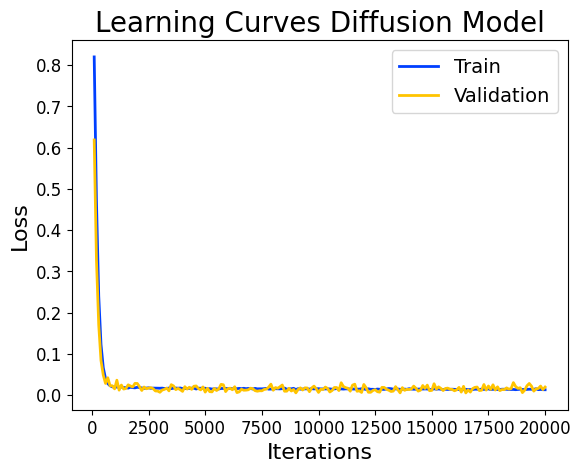

In [9]:
n_iterations = 1e4 # training for longer (1e4 ~ 3h) helps a lot with reconstruction quality, even if the loss is already low
batch_size = 64
val_interval = 100
iter_loss_list, val_iter_loss_list = [], []
iterations = []
iteration, iter_loss = 0, 0

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True, persistent_workers=True
)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True, persistent_workers=True
)

total_start = time.time()

while iteration < n_iterations:
    for batch in train_loader:
        iteration += 1
        model.train()
        optimizer.zero_grad(set_to_none=True)
        images= batch["image"].to(device)        
        noise = torch.randn_like(images).to(device)
        # Create timesteps
        timesteps = torch.randint(0, inferer.scheduler.num_train_timesteps, (batch_size,)).to(device).long()
        # Get model prediction
        # cross attention expects shape [batch size, sequence length, channels], we are use channels = latent dimension and sequence length = 1
        latent = model.semantic_encoder(images)
        noise_pred = inferer(inputs=images, diffusion_model=model.unet, noise=noise, timesteps=timesteps, condition = latent.unsqueeze(2))
        loss = F.mse_loss(noise_pred.float(), noise.float())

        loss.backward()
        optimizer.step()
        
        iter_loss += loss.item()
        sys.stdout.write(f"Iteration {iteration}/{n_iterations} - train Loss {loss.item():.4f}" + "\r")
        sys.stdout.flush()

        if (iteration) % val_interval == 0:
            model.eval()
            val_iter_loss = 0
            for val_step, val_batch in enumerate(val_loader):
                with torch.no_grad():
                    images = val_batch["image"].to(device)
                    timesteps = torch.randint(0, inferer.scheduler.num_train_timesteps, (batch_size,)).to(device).long()
                    noise = torch.randn_like(images).to(device)
                    latent = model.semantic_encoder(images)
                    noise_pred = inferer(inputs=images, diffusion_model=model.unet, noise=noise, timesteps=timesteps, condition = latent.unsqueeze(2))
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())
                    
                val_iter_loss += val_loss.item()
            iter_loss_list.append(iter_loss / val_interval)
            val_iter_loss_list.append(val_iter_loss / (val_step + 1))
            iterations.append(iteration)
            iter_loss = 0
            print(f"Iteration {iteration} - Interval Loss {iter_loss_list[-1]:.4f}, Interval Loss Val {val_iter_loss_list[-1]:.4f}")


total_time = time.time() - total_start

print(f"train diffusion completed, total time: {total_time}.")

plt.style.use("seaborn-bright")
plt.title("Learning Curves Diffusion Model", fontsize=20)

plt.plot(iterations, iter_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(iterations, val_iter_loss_list, color="C4", linewidth=2.0, label="Validation")

plt.yticks(fontsize=12), plt.xticks(fontsize=12)
plt.xlabel("Iterations", fontsize=16), plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

# Evaluation
## Generate synthetic data

We use the semantic encoder to get a latent space from the validation dataset. We then use the diffusion model to generate synthetic data from the latent space.

In [10]:
scheduler.set_timesteps(num_inference_steps=100)
batch = next(iter(val_loader))
images = batch["image"].to(device)        
noise = torch.randn_like(images).to(device)
latent = model.semantic_encoder(images)
reconstruction = inferer.sample(input_noise=noise, diffusion_model=model.unet, scheduler=scheduler, save_intermediates=False, conditioning=latent.unsqueeze(2))

100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


(-0.5, 529.5, 133.5, -0.5)

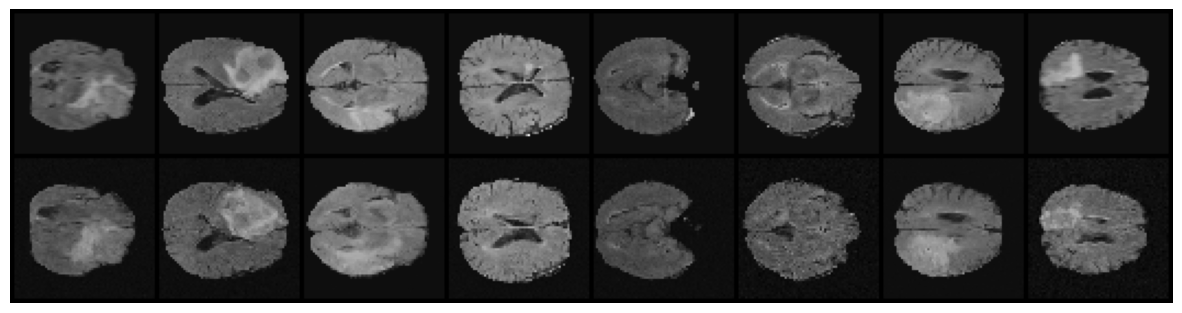

In [11]:
grid = torchvision.utils.make_grid(torch.cat([images[:8],reconstruction[:8]]), nrow=8, padding=2, normalize=True, range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,5))
plt.imshow(grid.detach().cpu().numpy()[0], cmap= 'gray')
plt.axis('off')

## Evaluate Latent Space

First, obtain the latent space from the entire training and validation datasets.
Then, we train a logistic regression classifier on the latent space.

In [12]:
# get latent space of training set
latents_train = []
classes_train = []
# 15 slices from each volume
nb_slices_per_volume = 15
for _ in range(nb_slices_per_volume): 
    for batch in train_loader:
        images = batch["image"].to(device)
        latent = model.semantic_encoder(images)
        latents_train.append(latent.detach().cpu().numpy())
        classes_train.append(batch["slice_label"].numpy())
    
latents_train = np.concatenate(latents_train, axis=0)   
classes_train = np.concatenate(classes_train, axis=0)   

# get latent space of validation set
latents_val = []
classes_val = []
for batch in val_loader:
    images = batch["image"].to(device)
    latent = model.semantic_encoder(images)
    latents_val.append(latent.detach().cpu().numpy())
    classes_val.append(batch["slice_label"].numpy())
latents_val = np.concatenate(latents_val, axis=0)
classes_val = np.concatenate(classes_val, axis=0)

In [13]:
latents_train.shape , classes_train.shape

((5760, 512), (5760,))

In [14]:
clf = LogisticRegression(solver = 'newton-cg', random_state=0).fit(latents_train, classes_train)
clf.score(latents_train, classes_train), clf.score(latents_val, classes_val)

The line search algorithm did not converge
Line Search failed


(0.8885416666666667, 0.78125)

In [15]:
w = torch.Tensor(clf.coef_).float().to(device)

## Manipulate Latent Space

The logistic regression classifier learns a direction `w` in the latent space that separates the healthy and abnormal slices. We can use this direction to manipulate the images by `latent = latent + s * w`, where `s` controls the strength of the manipulation. Negative `s` will move the image in the opposite direction.

In [16]:
s = -1.5

scheduler.set_timesteps(num_inference_steps=100)
batch = next(iter(val_loader))
images = batch["image"].to(device)        
noise = torch.randn_like(images).to(device)

latent = model.semantic_encoder(images)

latent_manip = latent + s * w[0]

reconstruction = inferer.sample(input_noise=noise, diffusion_model=model.unet, scheduler=scheduler, save_intermediates=False, conditioning=latent.unsqueeze(1))
manipulated_images = inferer.sample(input_noise=noise, diffusion_model=model.unet, scheduler=scheduler, save_intermediates=False, conditioning=latent_manip.unsqueeze(1))

100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


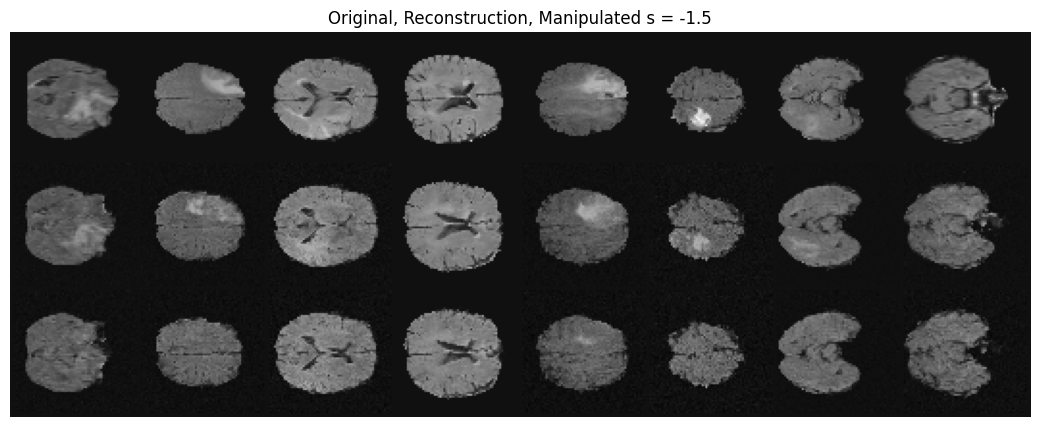

In [17]:
nb = 8
grid = torchvision.utils.make_grid(torch.cat([images[:nb], reconstruction[:nb], manipulated_images[:nb]]), 
                                   nrow=8,  normalize=False, range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,5))
plt.imshow(grid.detach().cpu().numpy()[0], cmap= 'gray')
plt.axis('off')
plt.title(f"Original, Reconstruction, Manipulated s = {s}");